<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Basic VaR calculation techniques
## Author: Gloria Rivas Nóvoa

## Index VaR calculation
The goal of the upcoming exercises will be to estimate value-at-risk for a single index (which can be seen as a portfolio value).


Let $Z_{t_0}, Z_{t_1},\ldots, Z_{t_N}$ be the index values at times $t_0,t_1,\ldots,t_N$.

Denote $X_i = Z_i - Z_{i-1}$ and $L_i = -X_i$.

### Exercise 0.
Fetch the data from Yahoo Finance via the script below and visualize it. Write some preliminary observations.

[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000   931800000
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971  1009000000
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044  1085500000
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985  1092300000
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951  1225200000
MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


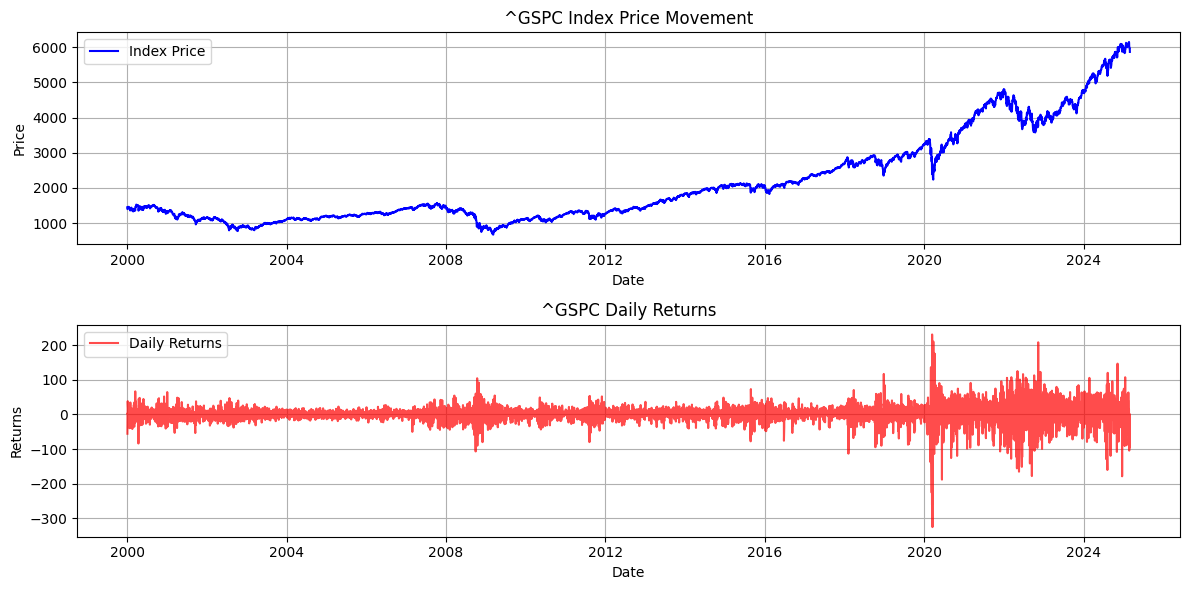

Preliminary Observations:
Time period: 2000-01-01 to 2025-02-28
Number of data points: 6327
Mean daily return: 0.6965
Standard deviation of returns: 26.4297
Maximum daily loss: 324.8901
Maximum daily gain: 230.3801


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ticker = "^GSPC" # SPX500
sp500_data = yf.download(ticker, start="2000-01-01", end="2025-02-28")
print(sp500_data.head())
print(sp500_data.columns)
symbol = "^GSPC"

sp500_data["Returns"] = sp500_data[("Close", "^GSPC")].diff()
sp500_data["Losses"] = -sp500_data["Returns"]

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data[("Close", "^GSPC")], label="Index Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"{symbol} Index Price Movement")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data["Returns"], label="Daily Returns", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title(f"{symbol} Daily Returns")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


print("Preliminary Observations:")
print(f"Time period: 2000-01-01 to 2025-02-28")
print(f"Number of data points: {len(sp500_data)}")
print(f"Mean daily return: {sp500_data['Returns'].mean():.4f}")
print(f"Standard deviation of returns: {sp500_data['Returns'].std():.4f}")
print(f"Maximum daily loss: {sp500_data['Losses'].max():.4f}")
print(f"Maximum daily gain: {sp500_data['Returns'].max():.4f}")


### Exercise 1.

#### Variance-Covariance approach to (index) VaR

Assumption: return at day $t_i$, $X_i$, has normal distribution $\mathcal{N}(\mu_t, \sigma_t^2)$.
Value of VaR at day $t$ is calculated by historical estimation of mean $\mu_t$ and $\sigma_t^2$ for a given time window $n$.

Two most common approaches are to parameter estimation are:
- unbiased estimators of $\mu_t$ and $\sigma^2_t$;
- exponentially weighted moving average estimation (EWMA)

The idea behind EWMA is to put more weights into more recent observations. Concretely, for a given parameter $\lambda\in(0,1]$
- $\hat{\mu}_t = c\sum_{i=1}^n X_{t-i} \lambda^{i-1}$
- $\hat{\sigma}_{t}^2 = c\sum_{i=1}^n (X_{t-i} - \hat{\mu}_t)^2\lambda^{i-1}$,

where $c$ is a normalizing constant. Note that $\lambda=1$ should return unbiased estimators.

### Historical (index) VaR

Assumption: VaR at day $t$ is computed as a $p$-th quantile of the last $n$ observations


In [3]:
import numpy.typing as npt
import numpy as np
from scipy.stats import norm

np.random.seed(1)

def variance_covariance_index_var(
    returns: npt.NDArray[np.double],
    confidence_level: float,
    obs_window_size: int = 250,
    lam: float = 0.94
) -> npt.NDArray[np.double]:

    n = len(returns)
    var_values = np.full(n, np.nan)

    z_score = norm.ppf(1 - confidence_level)

    for t in range(obs_window_size, n):
        past_returns = returns[t - obs_window_size:t]
        weights = np.array([lam ** (obs_window_size - i) for i in range(1, obs_window_size + 1)])
        weights /= weights.sum()

        ewma_mean = np.sum(weights * past_returns)
        ewma_var = np.sum(weights * (past_returns - ewma_mean) ** 2)

        var_values[t] = ewma_mean + z_score * np.sqrt(ewma_var)

    return var_values


def historical_index_var(
    returns: npt.NDArray[np.double],
    confidence_level: float,
    obs_window_size: int = 250,
) -> npt.NDArray[np.double]:
    n = len(returns)
    var_values = np.full(n, np.nan)

    for t in range(obs_window_size, n):
        past_returns = returns[t - obs_window_size:t]
        var_values[t] = np.percentile(past_returns, (1 - confidence_level) * 100)

    return var_values

### Exercise 2.

#### Backtesting

The goal of VaR backtesting is to evaluate the performance of VaR models. A VaR estimate with a 95% confidence level should only be violated about 5% of the time, and VaR failures should not cluster. Clustering of VaR failures indicates a lack of independence across time, indicating that the VaR models are slow to react to changing market conditions.


Backtest the methods implemented in Exercise 1. Use default value of the obs_window_size and try with lambda = 0.94 and = 1.0 for the parametric method.

Visualize and comment on the results.

Backtest for Variance-Covariance (λ=0.94):
Expected Breach Rate: 5.00%
Actual Breach Rate: 5.47%


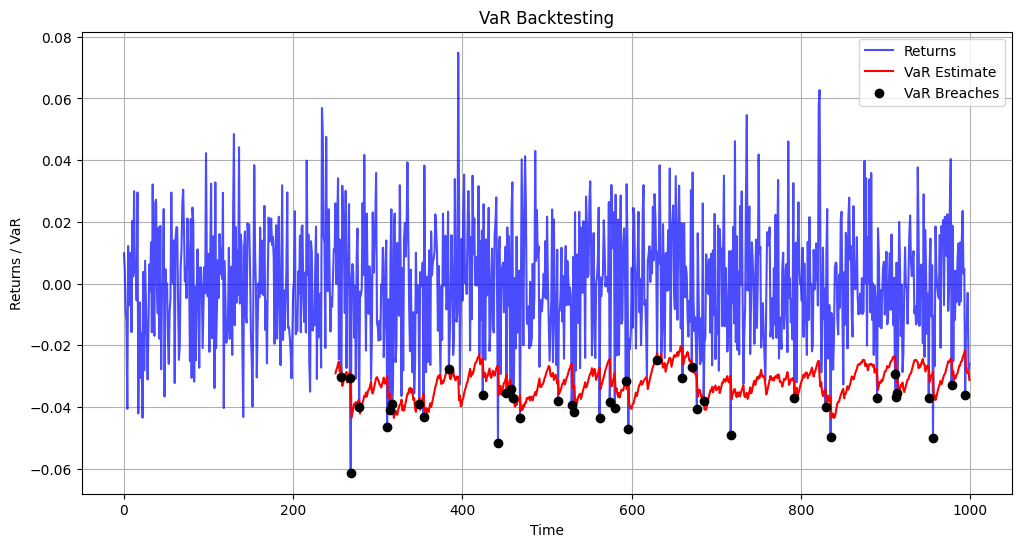

Backtest for Variance-Covariance (λ=1.0):
Expected Breach Rate: 5.00%
Actual Breach Rate: 5.07%


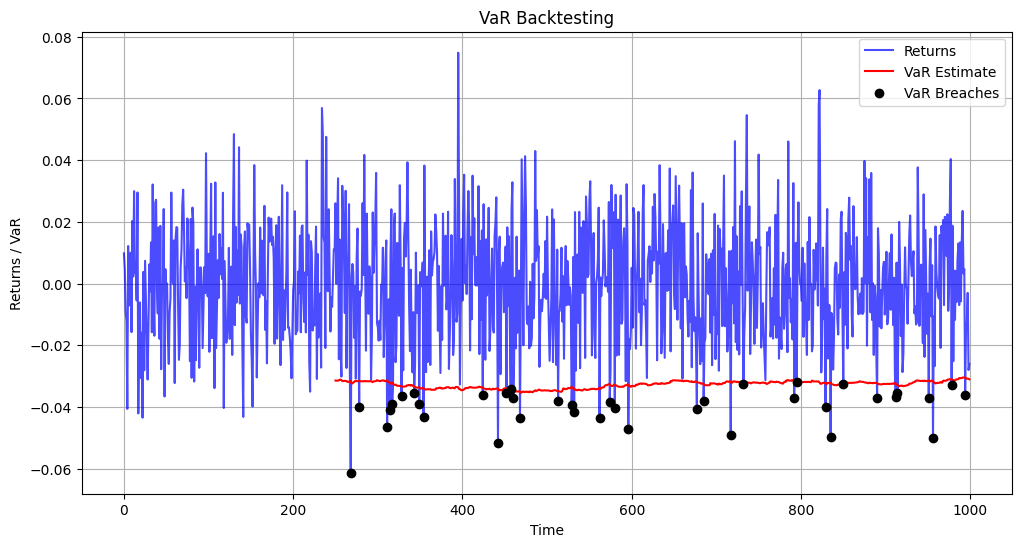

Backtest for Historical VaR:
Expected Breach Rate: 5.00%
Actual Breach Rate: 5.87%


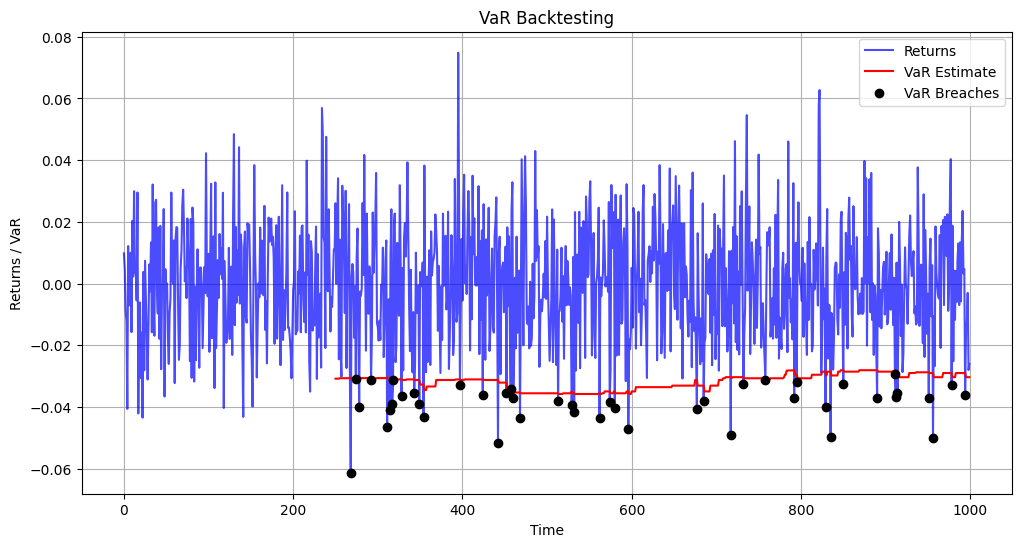

In [6]:
def backtest_var(
    returns: npt.NDArray[np.double],
    var_estimates: npt.NDArray[np.double],
    confidence_level: float
) -> None:
    """
    Backtests the VaR estimates by comparing them to actual returns.
    Highlights VaR breaches (where actual return is lower than VaR estimate).

    Parameters:
    - returns: Array of actual returns.
    - var_estimates: Array of estimated VaR values.
    - confidence_level: Confidence level of the VaR (e.g., 0.95).
    """
    var_breaches = returns < var_estimates
    breach_rate = np.mean(var_breaches[~np.isnan(var_estimates)])
    expected_breach_rate = 1 - confidence_level

    print(f"Expected Breach Rate: {expected_breach_rate:.2%}")
    print(f"Actual Breach Rate: {breach_rate:.2%}")

    plt.figure(figsize=(12, 6))
    plt.plot(returns, label='Returns', color='blue', alpha=0.7)
    plt.plot(var_estimates, label='VaR Estimate', color='red')
    plt.scatter(np.where(var_breaches)[0], returns[var_breaches], color='black', label='VaR Breaches', zorder=3)
    plt.xlabel("Time")
    plt.ylabel("Returns / VaR")
    plt.title("VaR Backtesting")
    plt.legend()
    plt.grid()
    plt.show()

confidence_level = 0.95
obs_window_size = 250

returns = np.random.normal(0, 0.02, 1000)

var_ewma_094 = variance_covariance_index_var(returns, confidence_level, obs_window_size, lam=0.94)
var_ewma_100 = variance_covariance_index_var(returns, confidence_level, obs_window_size, lam=1.0)
var_hist = historical_index_var(returns, confidence_level, obs_window_size)

print("Backtest for Variance-Covariance (λ=0.94):")
backtest_var(returns, var_ewma_094, confidence_level)

print("Backtest for Variance-Covariance (λ=1.0):")
backtest_var(returns, var_ewma_100, confidence_level)

print("Backtest for Historical VaR:")
backtest_var(returns, var_hist, confidence_level)

#CONCLUSIONS
In general, we can say that the number of black dots, which represent VaR Breaches (Times When Actual Returns Are Worse Than VaR) seems reasonable, as it is below the graph in aprox. 5% of the cases, meaning that the VaR model is mostly well-calibrated.
Futhermore, we can observe that λ=0.94 gives more weight to recent observations, resulting in a better adaptation to volatility shifts. Meanwhile, λ=1.0 assumes all past data is equally important, leading to slow reactions to market changes. This can be noticed in the fact that, for this second graph, there are many breaches together in some periods(clustering), while in others, there are few or no breaches.

Finally, for the third graph, corresponding to (Historical VaR), as this method does not assume normality, it captures extreme events better, but might lag in adapting to sudden shifts in market volatility. As a result, fewer breaches are shown than in the second graph, but still some clustering.

Comparing the breach rates, it is proved that Model 1 underestimates risk slightly, even though it seems like it is more adaptative to changes than Model 2. Instead, Model 3 is the most accurate, with a 5.33% of breach rates vs the 5% expected.

## Portfolio VaR calculation

Let $Z_{t_i}\in\mathbb{R}^d$ be a vector of **risk factors** and as before, put $X_i = Z_i - Z_{i-1} \in \mathbb{R}^d$.

Let $V_t = f(t, Z_{t})\in\mathbb{R}$ be the value of the portfolio at time $t$, and $L_t = f(t-1, Z_{t-1}) - f(t, Z_t)$.

Using linear approximation, one can write
$$L_t \approx L^\Delta_t := a_t + b_t^TX_t$$
for some $a_t\in\mathbb{R}$, $b_t\in\mathbb{R}^d$ (appropriate derivatives of $L$).

Variance-Covariance method of portfolio VaR calculation:
- assume $X_t\sim \mathcal{N}(\mu_t, \Sigma_t)$
- estimate $\mu_t, \Sigma_t$ (using regular unbiased estimators)
- use linear approximation above (assume fixed, constant $a_t\equiv a$, $b_t\equiv b$)


### Exercise 3.
- fetch a >=5-year history of data of >=20 stocks (pick your favorites) from yfinance
- construct a fixed portfolio of those stocks (sample weights wector $w$ randomly)
- calculate $a_t$ and $b_t$ from the linearization equation, given $f(t,Z_t) = w^T Z_t$
- calculate VaR using variance-covariance method above for the last 2 years of observations
- backtest your calculations
- visualize results and write your observations

Let's first calculate $a_t$ and $b_t$ from the formula:
<br>By substituting
$
f(t, Z_t) = w^T Z_t
$
we get:

$$
L_t = w^T Z_{t-1} - w^T Z_t = w^T (Z_{t-1} - Z_t) = -w^T X_t
$$

Thus, comparing to:

$$
L_t \approx a_t + b_t^T X_t
$$

we identify:

$$
a_t = 0, \quad b_t = -w
$$


[*********************100%***********************]  20 of 20 completed


Ticker           AAPL       AMZN          C       CSCO         DIS      GOOGL  \
Date                                                                            
2018-01-02  40.479836  59.450500  58.050426  31.172997  107.399292  53.405170   
2018-01-03  40.472786  60.209999  58.229973  31.421675  107.860390  54.316319   
2018-01-04  40.660782  60.479500  58.948193  31.510578  107.812370  54.527306   
2018-01-05  41.123726  61.457001  58.870132  31.946983  107.226364  55.250351   
2018-01-08  40.970970  62.343498  58.183125  32.278336  105.689354  55.445419   

Ticker             IBM       INTC        JPM         KO        META  \
Date                                                                  
2018-01-02  105.983513  39.330379  88.111282  36.272209  180.568985   
2018-01-03  108.896767  37.995590  88.201065  36.192558  183.803741   
2018-01-04  111.102310  37.298820  89.464622  36.702324  183.465332   
2018-01-05  111.645126  37.559063  88.890266  36.694351  185.973526   
2018-0

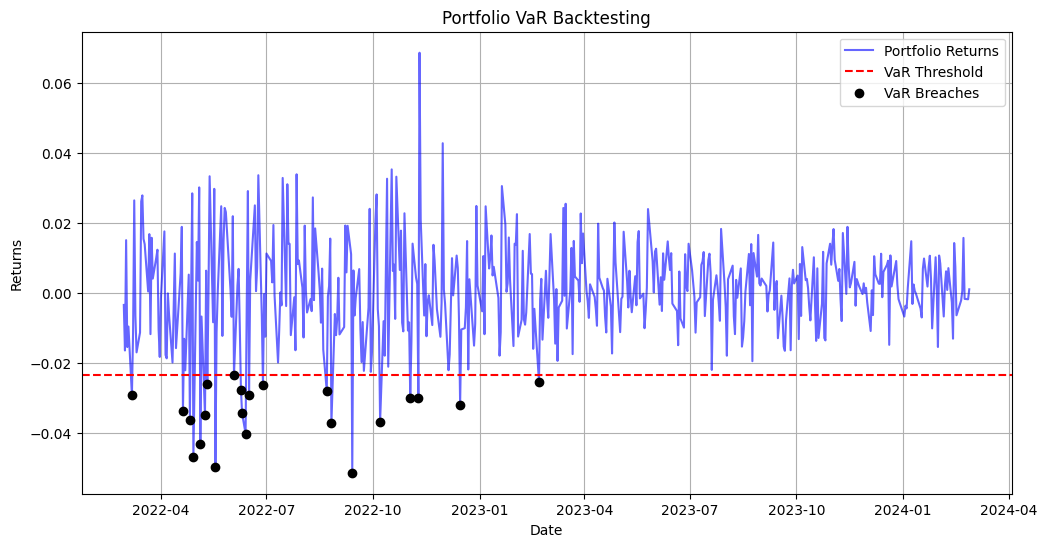

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "NFLX", "JPM", "V",
           "PG", "DIS", "INTC", "PFE", "KO", "PEP", "XOM", "CSCO", "C", "IBM"]

data = yf.download(tickers, start="2018-01-01", end="2024-02-28")["Close"]
print(data.head())

returns = data.pct_change().dropna()
start_date = "2022-02-28"
returns_last_2y = returns.loc[start_date:]

np.random.seed(42)
weights = np.random.rand(len(tickers))
weights /= weights.sum()

portfolio_returns = returns_last_2y @ weights

mu_t = np.mean(returns_last_2y, axis=0)
Sigma_t = np.cov(returns_last_2y.T)

a = 0
b = -weights

portfolio_variance = b.T @ Sigma_t @ b
portfolio_std = np.sqrt(portfolio_variance)

confidence_level = 0.95
Z_c = norm.ppf(1 - confidence_level)
portfolio_VaR = np.abs(Z_c * portfolio_std)

print(f"Portfolio VaR (95% confidence): {portfolio_VaR:.4f}")

var_breaches = portfolio_returns < -portfolio_VaR
breach_rate = np.mean(var_breaches)

print(f"Expected Breach Rate: {1 - confidence_level:.2%}")
print(f"Actual Breach Rate: {breach_rate:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.index, portfolio_returns, label="Portfolio Returns", color="blue", alpha=0.6)
plt.axhline(-portfolio_VaR, color="red", linestyle="--", label="VaR Threshold")
plt.scatter(portfolio_returns.index[var_breaches], portfolio_returns[var_breaches], color="black", label="VaR Breaches", zorder=3)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Portfolio VaR Backtesting")
plt.legend()
plt.grid()
plt.show()


#CONCLUSIONS
First thing that we can notice is that VaR Model is well-calibrated as the Expected Breach Rate is 5.00% and the Actual Breach Rate is 4.38%, suggesting a correct estimation (not very conservative or too loose; the small difference below the threshold may indicate slightly overestimating risk, but this is preferable in risk management).
<br>Futhermore, we can observe how periods of high volatility and inestability show more breaches; we see clusters of breaches in mid 2022 and fewer in 2023 and early 2024, suggesting that market stability increased.

## References:
- https://www.mathworks.com/help/risk/value-at-risk-estimation-and-backtesting.html
- McNeil, Frey, Embrechts "Quantitative Risk Management", Sec. 2.1, 2.3